EE488 HW 1-2: Anomaly detection using a reconstruction task
====

## Instruction
- In this practice, we will detect anomalous data using the reconstruction model
- Using the MNIST dataset, define images corresponding to digit 0 as normal data. The rest of digits (1 -- 9) are considered as anomalies.
- Modify the "Data Loader" section such that only digit 0 is included as training data.
- The test dataset includes all digits from 0 to 9
- Run the training and calculate the RMS errors for individual digits of test dataset. Fill the "Histogram Comparison" section to plot the histogram similar to the given image.  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as vision_dsets
import torchvision.transforms as T
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
import matplotlib.pyplot as plt
import matplotlib as mpl


### Data Loader

In [2]:
root='./data'
batch_size=32

mnist_train = vision_dsets.MNIST(root = root,
                                train = True,
                                transform = T.ToTensor(),
                                download = True)

idx = mnist_train.targets == 0

mnist_train.targets = mnist_train.targets[idx]
mnist_train.data = mnist_train.data[idx]

mnist_test = vision_dsets.MNIST(root = root,
                                train = False,
                                transform = T.ToTensor(),
                                download = True)

trainDataLoader = data.DataLoader(dataset = mnist_train,
                                    batch_size = batch_size,
                                    shuffle =True,
                                    num_workers = 1)

testDataLoader = data.DataLoader(dataset = mnist_test,
                                batch_size = batch_size,
                                shuffle = False,
                                num_workers = 1)



### **Define Neural Network for AE training**

In [3]:
class AE(nn.Module):
    def __init__(self, z_dim=256):
        super(AE, self).__init__()

        # encoder part
        self.encconv1 = nn.Conv2d(1,16,5)
        self.encconv2 = nn.Conv2d(16,32,5)

        # latent encoding & decoding
        self.encfc = nn.Linear(32*20*20, z_dim)
        self.decfc = nn.Linear(z_dim, 32*20*20)

        # decoder part
        self.decconv1 = nn.ConvTranspose2d(32,16,5)
        self.decconv2 = nn.ConvTranspose2d(16,1,5)

    def encoder(self, x):
        # encoder
        # first cnn layer
        x = F.relu(self.encconv1(x))

        # second cnn layer
        x = F.relu(self.encconv2(x))
        x = x.view(-1, 32*20*20)    # flatten

        # latent
        z = self.encfc(x)

        return z

    def decoder(self, z):
        # reconstruct image from latent z

        x = F.relu(self.decfc(z))
        x = x.view(-1, 32, 20, 20) # unflatten

        # first deconv layer
        x = F.relu(self.decconv1(x))

        # second deconv layer
        x = torch.sigmoid(self.decconv2(x))
        return x

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

### **Define AE Trainer**

In [4]:
class AETrainer():
    def __init__(self, trainloader, testloader, net, optimizer):

        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer

    def mse_loss(self, recon_x, x):
        # compute mse loss
        mseloss = F.mse_loss(recon_x.view(-1,1,28,28), x, reduction='sum')

        return mseloss

    def train(self, epoch = 1, test_on_train=False):
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0
            for i, (inputs, _) in enumerate(self.trainloader, 0):
                inputs = inputs.cuda()
                self.optimizer.zero_grad()

                # forward
                recon =self.net(inputs)

                # compute loss
                loss = self.mse_loss(recon, inputs)

                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if (i+1) % 100 == 0:
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / (100*len(inputs))))
                    running_loss = 0.0
            if test_on_train:
                self.test()
        print('Finished Training')

    def test(self):
        self.net.eval()

        test_loss = 0
        with torch.no_grad():
            for inputs, _ in self.testloader:
                inputs = inputs.cuda()
                # forward
                recon = self.net(inputs)

                # compute loss
                loss = self.mse_loss(recon, inputs)
                test_loss += loss.item()

            test_loss /= len(self.testloader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))

In [5]:
z_dim = 64
ae_net = AE(z_dim=z_dim).cuda()
optimizer = optim.Adam(ae_net.parameters(), lr=1e-4)

In [6]:
trainer = AETrainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = ae_net,
                  optimizer = optimizer)

In [7]:
trainer.train(epoch = 10, test_on_train=True)

[1,   100] loss: 83.534
====> Test set loss: 60.8545
[2,   100] loss: 27.418
====> Test set loss: 47.9151
[3,   100] loss: 20.802
====> Test set loss: 43.2433
[4,   100] loss: 17.709
====> Test set loss: 40.0196
[5,   100] loss: 15.875
====> Test set loss: 38.4977
[6,   100] loss: 14.941
====> Test set loss: 36.9565
[7,   100] loss: 14.021
====> Test set loss: 35.8997
[8,   100] loss: 13.542
====> Test set loss: 35.0018
[9,   100] loss: 13.261
====> Test set loss: 34.1675
[10,   100] loss: 12.823
====> Test set loss: 33.3544
Finished Training


## Compare original and reconstructed images

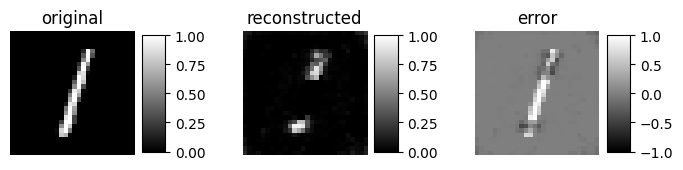

In [19]:
test_digit = 1

zero_org = mnist_test.data[mnist_test.targets==test_digit].data.view(-1,1,28,28).cuda()
zero_org = zero_org/255.0
zero_recon = ae_net(zero_org)

zero_org = zero_org.detach().cpu().view(-1,28,28)
zero_recon = zero_recon.detach().cpu().view(-1,28,28)

fig, axes = plt.subplots(1,3,figsize=(8,8))
ax = axes.ravel()

# define colorbars
imidx = 0

im0 = ax[0].imshow(zero_org[imidx], cmap='gray', vmin=0, vmax=1)
ax[0].axis('off')
ax[0].set_title('original')
im1 = ax[1].imshow(zero_recon[imidx], cmap='gray', vmin=0, vmax=1)
ax[1].axis('off')
ax[1].set_title('reconstructed')
im2 = ax[2].imshow(zero_org[imidx]-zero_recon[imidx], cmap='gray', vmin=-1, vmax=1)
ax[2].axis('off')
ax[2].set_title('error')

fig.colorbar(im0, ax=ax[0], aspect=5, shrink= 0.5, pad=0.05)
fig.colorbar(im1, ax=ax[1], aspect=5, shrink= 0.5, pad=0.05)
fig.colorbar(im2, ax=ax[2], aspect=5, shrink= 0.5, pad=0.05)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


## Histogram comparison
In this section, we calculate reconstruction errors for individual digits and plot histogram to compare the error distribution between seen and unseen data during training.

An example figure is also given below.

<Figure size 1000x1000 with 0 Axes>

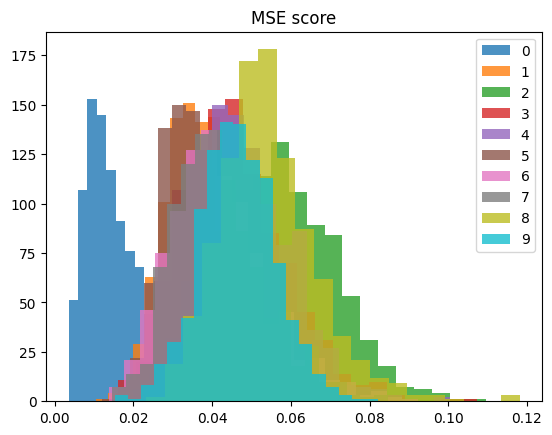

<Figure size 1000x1000 with 0 Axes>

In [ ]:
for i in range(10):

  org = mnist_test.data[mnist_test.targets==i].data.view(-1,1,28,28).cuda()
  org = org/255.0
  recon = ae_net(org)

  loss = F.mse_loss(recon, org, reduction='none')
  loss = loss.view(loss.size(0), -1).mean(dim=1).detach().cpu().numpy()
  
  plt.hist(loss, bins= 20, alpha = 0.8)  # plot the histogram of calculated loss

plt.title('MSE score')
plt.legend(['0','1','2','3','4','5','6','7','8','9'])
plt.figure(figsize=(10,10))



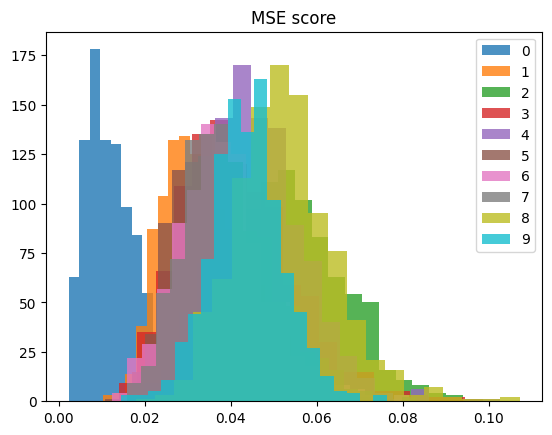